## Building a Deep Learning Model that can Lip Read

### 0. Install and Import Dependencies

In [1]:
# !pip install opencv-python matplotlib imageio tensorflow gdown

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

2025-07-20 09:29:03.860623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

### 1. Build Data Loading Functions

In [5]:
import gdown

In [6]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [7]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()}"
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


2025-07-20 09:29:06.496037: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
char_to_num(['a', 'd', 'i']), num_to_char([1, 4, 9])

(<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 4, 9])>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'd', b'i'], dtype=object)>)

In [11]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [13]:
test_path = 'data/s1/lgbf8n.mpg'

In [14]:
bytes.decode(tf.convert_to_tensor(test_path).numpy())

'data/s1/lgbf8n.mpg'

In [15]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'lgbf8n'

In [16]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [17]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.348085  ],
         [10.348085  ]],

        [[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.348085  ],
         [10.348085  ]],

        [[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.348085  ],
         [10.348085  ]],

        ...,

        [[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.348085  ],
         [10.348085  ]],

        [[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.348085  ],
         [10.348085  ]],

        [[10.348085  ],
         [10.348085  ],
         [10.348085  ],
         ...,
         [10.348085  ],
         [10.34808

In [18]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  2, 25, 39,  6, 39,  5,  9,
        7,  8, 20, 39, 14, 15, 23])>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay green by f eight now'>

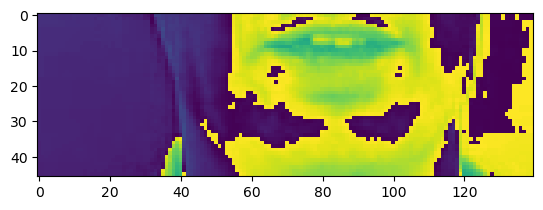

In [20]:
plt.imshow(frames[40])

In [21]:
def mappable_function(path: tf.Tensor):
    video, label = tf.py_function(load_data, [path], (tf.float32, tf.int64))

    # Set shapes for downstream operations (VERY important)
    video.set_shape((75, None, None, None))  # Time, H, W, C
    label.set_shape((40,))                   # Label length

    return video, label

### Create Data Pipeline

In [22]:
# Shuffle dataset
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)

# Map to (video, label)
data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)

# Apply padding and batching
data = data.padded_batch(2, padded_shapes=([75, None, None, None], [40]))

# Prefetch for performance
data = data.prefetch(tf.data.AUTOTUNE)

# Compute split sizes
train_size = int(0.8 * 32)  # Example: 80% train
train = data.take(train_size)
test = data.skip(train_size)

In [23]:
len(train), len(test), len(data)

(25, 7, 32)

In [24]:
frames, alignments = data.as_numpy_iterator().next()

2025-07-20 09:29:07.383542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]
2025-07-20 09:29:07.384058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]


In [25]:
len(frames)

2

In [26]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39,  9, 14, 39,  9, 39,
        20, 23, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  2, 25, 39,  6, 39, 14,
         9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [27]:
sample = data.as_numpy_iterator()

In [28]:
val = sample.next(); val[0]

array([[[[[ 1.5239341 ],
          [ 1.5239341 ],
          [ 1.5651215 ],
          ...,
          [ 0.04118741],
          [ 0.08237482],
          [ 0.08237482]],

         [[ 1.5239341 ],
          [ 1.5239341 ],
          [ 1.5651215 ],
          ...,
          [ 0.04118741],
          [ 0.08237482],
          [ 0.08237482]],

         [[ 1.4415593 ],
          [ 1.4415593 ],
          [ 1.4415593 ],
          ...,
          [ 0.04118741],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.9884978 ],
          [ 0.9884978 ],
          [ 0.9884978 ],
          ...,
          [10.296852  ],
          [10.296852  ],
          [10.296852  ]],

         [[ 0.9884978 ],
          [ 0.9884978 ],
          [ 0.9884978 ],
          ...,
          [10.255665  ],
          [10.255665  ],
          [10.255665  ]],

         [[ 0.9884978 ],
          [ 0.9884978 ],
          [ 0.9884978 ],
          ...,
          [10.255665  ],
          [10.255665  ],
          

In [29]:
frames = np.squeeze(val[0][0])
frames

array([[[ 1.5239341 ,  1.5239341 ,  1.5651215 , ...,  0.04118741,
          0.08237482,  0.08237482],
        [ 1.5239341 ,  1.5239341 ,  1.5651215 , ...,  0.04118741,
          0.08237482,  0.08237482],
        [ 1.4415593 ,  1.4415593 ,  1.4415593 , ...,  0.04118741,
          0.        ,  0.        ],
        ...,
        [ 0.9884978 ,  0.9884978 ,  0.9884978 , ..., 10.296852  ,
         10.296852  , 10.296852  ],
        [ 0.9884978 ,  0.9884978 ,  0.9884978 , ..., 10.255665  ,
         10.255665  , 10.255665  ],
        [ 0.9884978 ,  0.9884978 ,  0.9884978 , ..., 10.255665  ,
         10.255665  , 10.255665  ]],

       [[ 1.4827467 ,  1.4827467 ,  1.4827467 , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.4827467 ,  1.4827467 ,  1.4827467 , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.4415593 ,  1.4415593 ,  1.4827467 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.9884978 ,  0.9884978 ,  0.9473104 , ..., 1

In [30]:
frames_uint8 = (frames * 255).astype(np.uint8)
frames_uint8

array([[[132, 132, 143, ...,  10,  21,  21],
        [132, 132, 143, ...,  10,  21,  21],
        [111, 111, 111, ...,  10,   0,   0],
        ...,
        [252, 252, 252, ...,  65,  65,  65],
        [252, 252, 252, ...,  55,  55,  55],
        [252, 252, 252, ...,  55,  55,  55]],

       [[122, 122, 122, ...,   0,   0,   0],
        [122, 122, 122, ...,   0,   0,   0],
        [111, 111, 122, ...,   0,   0,   0],
        ...,
        [252, 252, 241, ...,  76,  65,  65],
        [252, 252, 241, ...,  65,  55,  55],
        [252, 252, 241, ...,  65,  55,  55]],

       [[122, 122, 122, ...,   0,   0,   0],
        [122, 122, 122, ...,   0,   0,   0],
        [111, 111, 101, ...,   0,   0,   0],
        ...,
        [252, 252, 241, ...,  76,  65,  65],
        [252, 252, 241, ...,  65,  55,  55],
        [241, 241, 241, ...,  65,  55,  55]],

       ...,

       [[101, 101, 111, ...,  10, 118, 118],
        [101,  90, 101, ...,  10, 118, 118],
        [122, 122, 122, ..., 118, 118, 118

In [31]:
imageio.mimsave("./animation.gif", frames_uint8, fps=10)

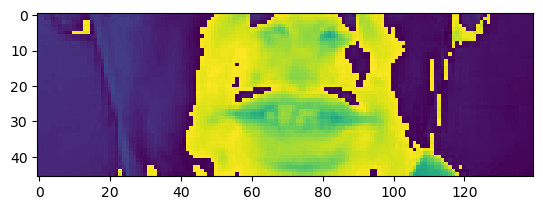

In [32]:
# val[videos][1st video of the batch][return the first frame in the video]
plt.imshow(val[0][1][35])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay red in y three again'>

### 3. Design the Deep Neural Network

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, \
BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
char_to_num.vocabulary_size()

40

In [37]:
model = Sequential()
model.add(Conv3D(32, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(32, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

2025-07-20 09:29:13.913207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:29:13.915317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:29:13.916739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 32)   896       
                                                                 
 activation (Activation)     (None, 75, 46, 140, 32)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 64)    55360     
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 64)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 64)   0         
 3D)                                                    

In [39]:
yhat = model.predict(val[0])
yhat

2025-07-20 09:29:15.170003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:29:15.171784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:29:15.174007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 2s 2s/step


array([[[0.02084316, 0.01927349, 0.02774192, ..., 0.02093888,
         0.01828434, 0.01831937],
        [0.0197833 , 0.01812803, 0.02740658, ..., 0.02173794,
         0.01788701, 0.01810973],
        [0.01886084, 0.01776216, 0.0269523 , ..., 0.02227029,
         0.0170482 , 0.01758908],
        ...,
        [0.01927901, 0.02206152, 0.02585392, ..., 0.02285863,
         0.01643685, 0.02579213],
        [0.01994595, 0.02362191, 0.02573674, ..., 0.02262788,
         0.01728614, 0.02681477],
        [0.02046405, 0.02585511, 0.02553629, ..., 0.02238874,
         0.01832068, 0.02728779]],

       [[0.02140903, 0.02002919, 0.0247913 , ..., 0.02026456,
         0.01824996, 0.01808607],
        [0.02060112, 0.01931592, 0.02405141, ..., 0.01985911,
         0.01778302, 0.0178777 ],
        [0.01985095, 0.01918599, 0.02341225, ..., 0.01949985,
         0.01712769, 0.01756133],
        ...,
        [0.01777738, 0.02092291, 0.02248251, ..., 0.01867046,
         0.01604313, 0.02112186],
        [0.0

In [40]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'666rrrrrrr666666666666666666rrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrrr6666666rrrrfff'>

In [41]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([35, 35, 35, 18, 18, 18, 18, 18, 18, 18, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 35, 35, 35, 35, 35, 35, 35,
       18, 18, 18, 18,  6,  6,  6])>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

### 4. Setup Training Options and Train

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr*tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
os.makedirs('models', exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join('models', 'checkpoint.weights.h5'),
    monitor='loss',
    save_weights_only=True
)

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

2025-07-20 09:29:26.899153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]
2025-07-20 09:29:26.899722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]


In [51]:
model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/5


2025-07-20 09:29:38.130799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]
2025-07-20 09:29:38.131637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [63]
	 [[{{node Placeholder/_0}}]]
2025-07-20 09:29:38.565588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with

25/25 [==============================] - ETA: 0s - loss: 165.2161  

2025-07-20 09:31:21.570880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:31:21.572935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:31:21.574422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 4s 4s/step
Original: place green at q six now
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green with l zero now
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
25/25 [==============================] - 152s 6s/step - loss: 165.2161 - val_loss: 134.7539 - lr: 1.0000e-04
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 138.4765  

[mpeg1video @ 0x752e800b39c0] ac-tex damaged at 22 17
[mpeg1video @ 0x752e800b39c0] Warning MVs not available


1/1 [==============================] - 1s 1s/step
Original: bin white by t seven soon
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay blue sp at q five soon
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
25/25 [==============================] - 136s 5s/step - loss: 138.4765 - val_loss: 125.7809 - lr: 1.0000e-04
Epoch 3/5
19/25 [=====================>........] - ETA: 23s - loss: 130.3370 

[mpeg1video @ 0x752e74040480] ac-tex damaged at 22 17
[mpeg1video @ 0x752e74040480] Warning MVs not available


25/25 [==============================] - ETA: 0s - loss: 129.4602 

[mpeg1video @ 0x752e04046ac0] ac-tex damaged at 22 17
[mpeg1video @ 0x752e04046ac0] Warning MVs not available


1/1 [==============================] - 1s 999ms/step
Original: lay red with r nine soon
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at p three again
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
25/25 [==============================] - 141s 6s/step - loss: 129.4602 - val_loss: 119.3519 - lr: 1.0000e-04
Epoch 4/5
18/25 [====================>.........] - ETA: 25s - loss: 125.3121 

[mpeg1video @ 0x752e781975c0] ac-tex damaged at 22 17
[mpeg1video @ 0x752e781975c0] Warning MVs not available


25/25 [==============================] - ETA: 0s - loss: 125.3121 

[mpeg1video @ 0x752e18076b40] ac-tex damaged at 22 17
[mpeg1video @ 0x752e18076b40] Warning MVs not available


1/1 [==============================] - 1s 579ms/step
Original: lay red in y three again
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place red by j five soon
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
25/25 [==============================] - 137s 5s/step - loss: 125.3121 - val_loss: 118.1676 - lr: 1.0000e-04
Epoch 5/5
 3/25 [==>...........................] - ETA: 1:16 - loss: 124.6026

[mpeg1video @ 0x752e8c179cc0] ac-tex damaged at 22 17
[mpeg1video @ 0x752e8c179cc0] Warning MVs not available


25/25 [==============================] - ETA: 0s - loss: 120.5958  

[mpeg1video @ 0x752e64050080] ac-tex damaged at 22 17
[mpeg1video @ 0x752e64050080] Warning MVs not available


1/1 [==============================] - 1s 644ms/step
Original: set red in t eight now
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white at m nine soon
Prediction: 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
25/25 [==============================] - 137s 5s/step - loss: 120.5958 - val_loss: 114.5396 - lr: 1.0000e-04


### 5. Make a Prediction

In [52]:
len(test)

7

In [53]:
test_data = test.as_numpy_iterator()

In [54]:
test_data.next()

[mpeg1video @ 0x752e104efb00] ac-tex damaged at 22 17
[mpeg1video @ 0x752e104efb00] Warning MVs not available


(array([[[[[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10.348085  ],
           [10.348085  ],
           [10.348085  ]],
 
          [[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10.348085  ],
           [10.348085  ],
           [10.348085  ]],
 
          [[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10.348085  ],
           [10.348085  ],
           [10.348085  ]],
 
          ...,
 
          [[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10.348085  ],
           [10.348085  ],
           [10.348085  ]],
 
          [[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10.348085  ],
           [10.348085  ],
           [10.348085  ]],
 
          [[10.348085  ],
           [10.348085  ],
           [10.348085  ],
           ...,
           [10

In [55]:
sample = test_data.next()

In [56]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()

In [58]:
print('~'*100, 'PREDICTIONS')  
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b''>,
 <tf.Tensor: shape=(), dtype=string, numpy=b''>]

In [59]:
print('~'*100, 'REAL TEXT')  
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay white at f zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green with p nine soon'>]

#### Using Nicholas's (youtube author who is teaching this tutorial) model architecture to make predictions

In [60]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'nicholas_model')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=343d4e6a-a858-465d-9aa4-c669e14a428f
To: /home/aditya/Public/Programming/data-science-projects-nicholas-renotte/building-a-deep-learning-model-that-can-lip-read/checkpoints.zip
100%|███████████████████████████████████████████████████████████| 94.5M/94.5M [03:47<00:00, 415kB/s]


['nicholas_model/checkpoint.index',
 'nicholas_model/__MACOSX/._checkpoint.index',
 'nicholas_model/checkpoint.data-00000-of-00001',
 'nicholas_model/__MACOSX/._checkpoint.data-00000-of-00001',
 'nicholas_model/checkpoint',
 'nicholas_model/__MACOSX/._checkpoint']

In [62]:
model2 = Sequential()
model2.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPool3D((1,2,2)))

model2.add(Conv3D(256, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPool3D((1,2,2)))

model2.add(Conv3D(75, 3, padding='same'))
model2.add(Activation('relu'))
model2.add(MaxPool3D((1,2,2)))

model2.add(TimeDistributed(Flatten()))

model2.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model2.add(Dropout(0.5))

model2.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model2.add(Dropout(0.5))

model2.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

2025-07-20 09:49:39.564998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:49:39.567008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:49:39.568463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [63]:
model2.load_weights('nicholas_model/checkpoint')

In [64]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [65]:
from tensorflow.keras.optimizers.legacy import Adam
model2.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [66]:
sample = test_data.next()

In [67]:
yhat = model2.predict(sample[0])

2025-07-20 09:50:42.114416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:50:42.118249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:50:42.119942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 9s 9s/step


In [68]:
decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()

In [69]:
print("~"*10, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set gren at p thre again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue by j zero please'>]

In [70]:
print('~'*100, 'REAL TEXT')  
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green at p three again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place blue by j zero please'>]

2025-07-20 09:51:35.546545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-07-20 09:51:35.550367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-07-20 09:51:35.556429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus